In [1]:
# ===========================
# PIPELINE LSTM SEMANAL MEJORADO
# ===========================

# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocesamiento y métricas
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# ===========================
# 1. Cargar y preparar los datos
# ===========================

df_productos_ranking = pd.read_csv("productos_ranking.csv")
df_productos_prioridad = pd.read_csv("productos_prioridad.csv")

df = pd.read_excel("DataHackathon.xlsx")

df = df[df['Cantidad'] != 0]
print((df['Cantidad'] == 0).sum())  

mask_unidades = df['Unidad de venta'].isin(['KG', 'L'])
mask_tres_ceros = df['Cantidad'] % 1000 == 0
mask_conversion = mask_unidades & mask_tres_ceros
df.loc[mask_conversion, 'Cantidad'] = df.loc[mask_conversion, 'Cantidad'] / 1000

df[mask_conversion][['Cantidad', 'Unidad de venta']]

articulos_top = df_productos_ranking['Articulo'].tolist()
df_top = df[df['Articulo'].isin(articulos_top)].copy()

# Agrupamos por semana
df_top['Semana'] = df_top['Creacion Orden de Venta'].dt.isocalendar().week
df_top['Anio'] = df_top['Creacion Orden de Venta'].dt.year

# Agregamos las cantidades por semana para cada producto
df_semanal = df_top.groupby(['Articulo', 'Anio', 'Semana']).agg({'Cantidad': 'sum'}).reset_index()

# Codificación de los artículos y normalización de las cantidades
le_articulo = LabelEncoder()
df_semanal['Articulo_encoded'] = le_articulo.fit_transform(df_semanal['Articulo'])

scalers = {}
for articulo in articulos_top:
    df_temp = df_semanal[df_semanal['Articulo'] == articulo]
    scaler = MinMaxScaler()
    df_semanal.loc[df_temp.index, 'Cantidad_scaled'] = scaler.fit_transform(df_temp[['Cantidad']])
    scalers[articulo] = scaler

0


In [3]:
# ===========================
# 2. Función para crear secuencias semanales
# ===========================

def crear_secuencias_semanales(df, articulo_id, sequence_length=12):
    df_art = df[df['Articulo_encoded'] == articulo_id].sort_values(['Anio', 'Semana'])
    
    df_art['Fecha'] = pd.to_datetime(df_art['Anio'].astype(str) + '-' + df_art['Semana'].astype(str) + '-1', format='%G-%V-%u')
    df_art.set_index('Fecha', inplace=True)

    serie = df_art['Cantidad_scaled'].resample('W').sum().reindex(
        pd.date_range(start=df_art.index.min(), end=df_art.index.max(), freq='W'),
        fill_value=0
    )
    
    sequences, targets = [], []
    data_qty = serie.values
    
    if len(data_qty) < sequence_length:
        return None, None

    for i in range(len(data_qty) - sequence_length):
        seq_qty = data_qty[i:i+sequence_length]
        seq_target = data_qty[i+sequence_length]
        
        sequences.append(seq_qty)
        targets.append(seq_target)
    
    articulo_array = np.full((len(sequences), 1), articulo_id)
    
    return [np.array(sequences), articulo_array], np.array(targets)


In [4]:

# ===========================
# 3. Crear el modelo LSTM
# ===========================

def crear_modelo(sequence_length, num_articulos, embedding_size=8, lstm_units=64, dropout_rate=0.2):
    input_qty = Input(shape=(sequence_length,))
    input_articulo = Input(shape=(1,))
    
    articulo_emb = Embedding(input_dim=num_articulos, output_dim=embedding_size)(input_articulo)
    articulo_emb_flat = tf.keras.layers.Flatten()(articulo_emb)
    
    x_qty = tf.keras.layers.Reshape((sequence_length, 1))(input_qty)
    lstm_out = LSTM(lstm_units)(x_qty)
    
    concat = Concatenate()([lstm_out, articulo_emb_flat])
    
    # 🔧 Nueva capa intermedia
    dense1 = Dense(64, activation='relu')(concat)
    drop1 = Dropout(dropout_rate)(dense1)
    
    # 💡 Capa adicional sugerida
    dense2 = Dense(32, activation='relu')(drop1)
    
    output = Dense(1, activation='linear')(dense2)
    
    model = Model(inputs=[input_qty, input_articulo], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [5]:
# ===========================
# 4. Entrenamiento y predicción por artículo (mejorado)
# ===========================
sequence_length = 12
resultados = []

for articulo_nombre in articulos_top:
    articulo_id = le_articulo.transform([articulo_nombre])[0]

    X, y = crear_secuencias_semanales(df_semanal, articulo_id=articulo_id, sequence_length=sequence_length)

    if X is None or len(X[0]) < 5:
        print(f" {articulo_nombre} no tiene suficientes datos para el entrenamiento. ({len(X[0]) if X else 0} muestras)")
        continue

    model = crear_modelo(sequence_length=sequence_length, num_articulos=len(articulos_top))

    print(f"Entrenando artículo: {articulo_nombre} con {len(X[0])} muestras")

    history = model.fit(
        X, y,
        epochs=30,
        batch_size=16,
        validation_split=0.2,
        callbacks=[
            EarlyStopping(patience=5, restore_best_weights=True),
            ReduceLROnPlateau(patience=3)
        ],
        verbose=0
    )

    # Predicción de 4 semanas futuras
    ultima_secuencia = X[0][-1]
    input_articulo = np.array([[articulo_id]])

    predicciones_futuras = []
    for i in range(4):
        pred = model.predict([ultima_secuencia.reshape(1, sequence_length, 1), input_articulo], verbose=0)
        predicciones_futuras.append(pred[0][0])
        ultima_secuencia = np.append(ultima_secuencia[1:], pred[0][0])

    # Desnormalizar y corregir negativos si aparecen
    scaler_producto = scalers[articulo_nombre]
    predicciones_futuras = scaler_producto.inverse_transform(np.array(predicciones_futuras).reshape(-1, 1))
    predicciones_futuras = np.clip(predicciones_futuras, 0, None)

    cantidad_total_predicha = np.sum(predicciones_futuras)

    # Métricas de entrenamiento
    pred_train = model.predict([X[0].reshape(-1, sequence_length, 1), X[1]], verbose=0)
    mae_train = mean_absolute_error(y, pred_train)
    mse_train = mean_squared_error(y, pred_train)

    resultados.append({
        'Articulo': articulo_nombre,
        'MAE_Train': mae_train,
        'MSE_Train': mse_train,
        'Cant_Pred_Fut_4semanas': cantidad_total_predicha
    })

Entrenando artículo: IVP01021 con 39 muestras
Entrenando artículo: IVP15248 con 40 muestras
Entrenando artículo: IVP15246 con 41 muestras
Entrenando artículo: IVP07378 con 126 muestras
Entrenando artículo: IVP07099 con 140 muestras
Entrenando artículo: IVP11065 con 122 muestras
Entrenando artículo: IVP11633 con 131 muestras
Entrenando artículo: IVP07383 con 53 muestras
Entrenando artículo: IVP04039 con 143 muestras
Entrenando artículo: IVP07293 con 140 muestras
Entrenando artículo: IVP07169 con 141 muestras
Entrenando artículo: IVP07370 con 141 muestras
Entrenando artículo: IVP07331 con 143 muestras
Entrenando artículo: IVP07243 con 134 muestras
Entrenando artículo: IVP11588 con 141 muestras
Entrenando artículo: IVP11080 con 142 muestras
Entrenando artículo: IVP11137 con 138 muestras
Entrenando artículo: IVP15237 con 51 muestras
Entrenando artículo: IVP07165 con 142 muestras
Entrenando artículo: IVP11060 con 138 muestras
Entrenando artículo: IVP07094 con 141 muestras
Entrenando artícul

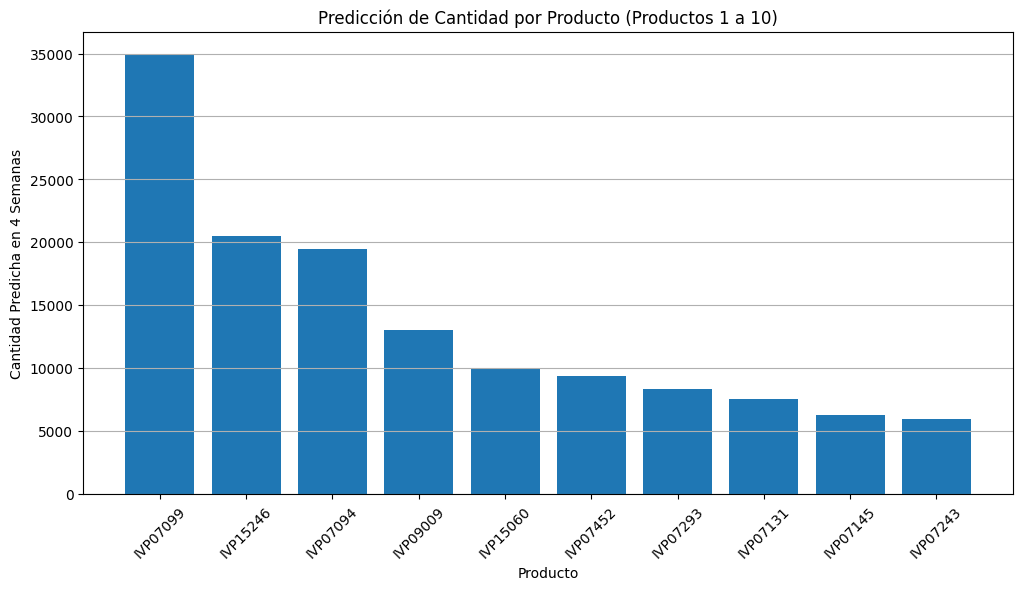

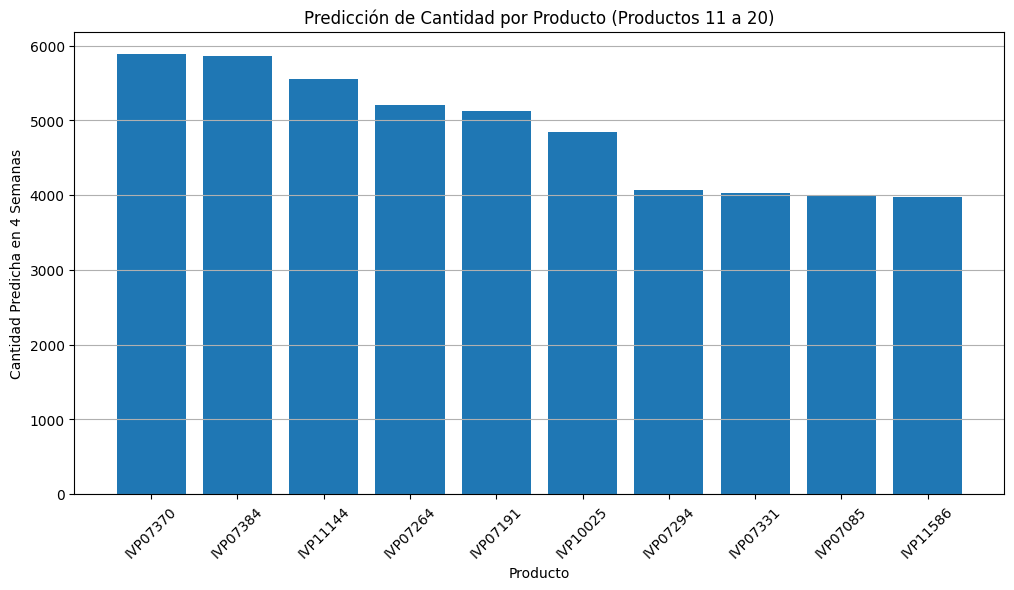

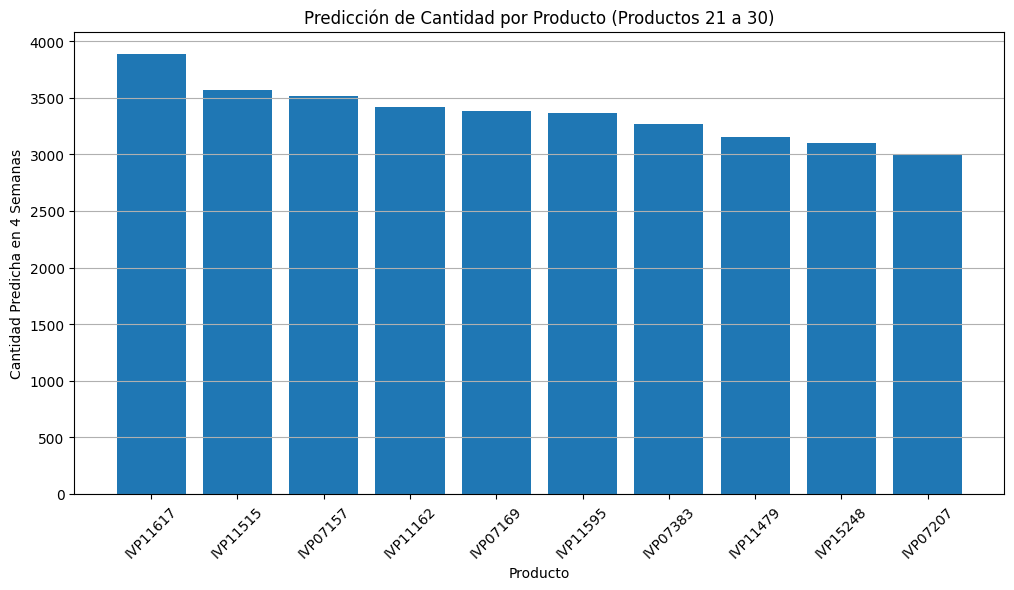

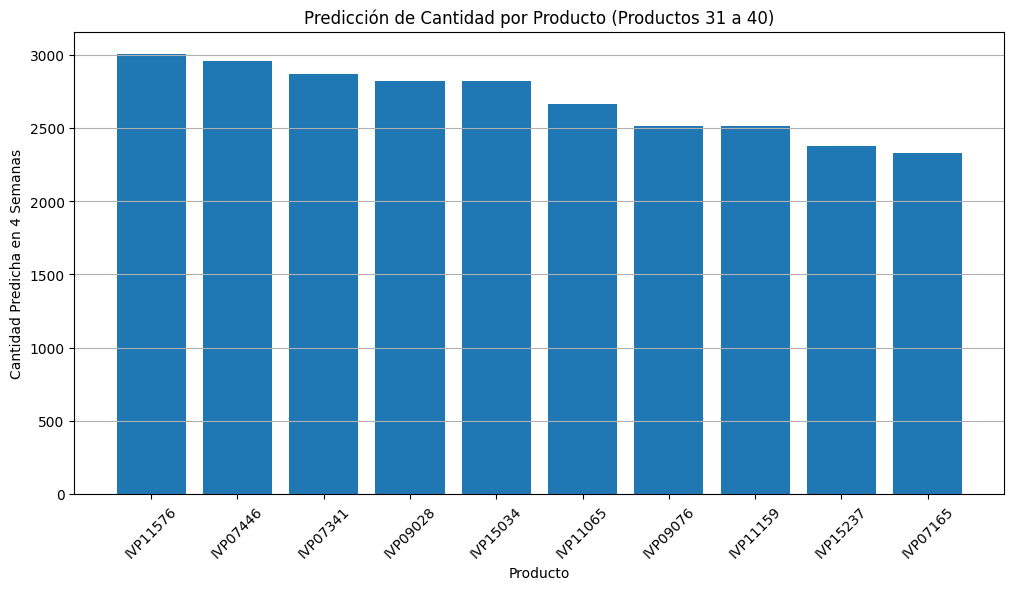

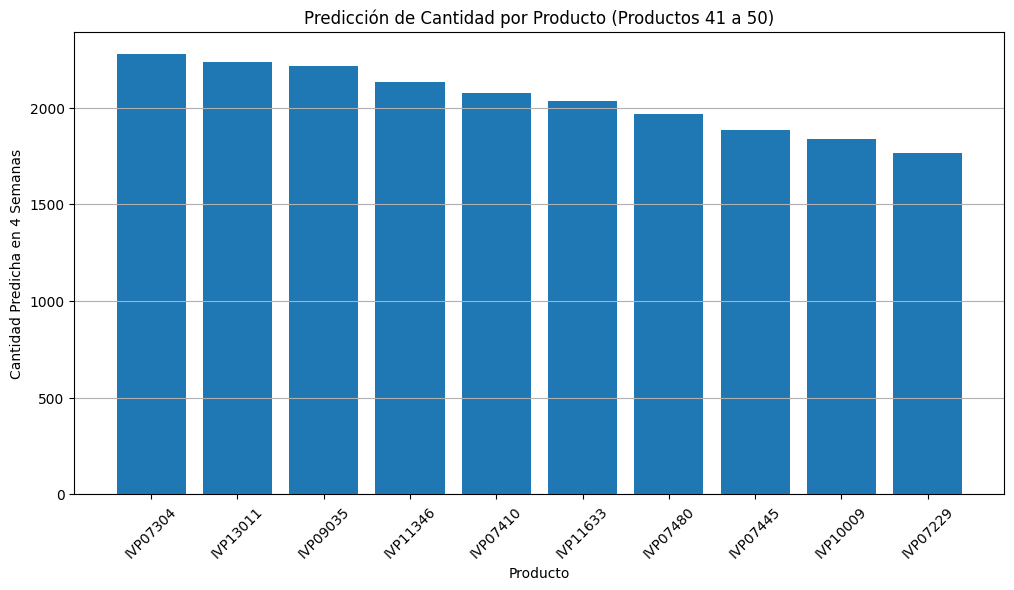

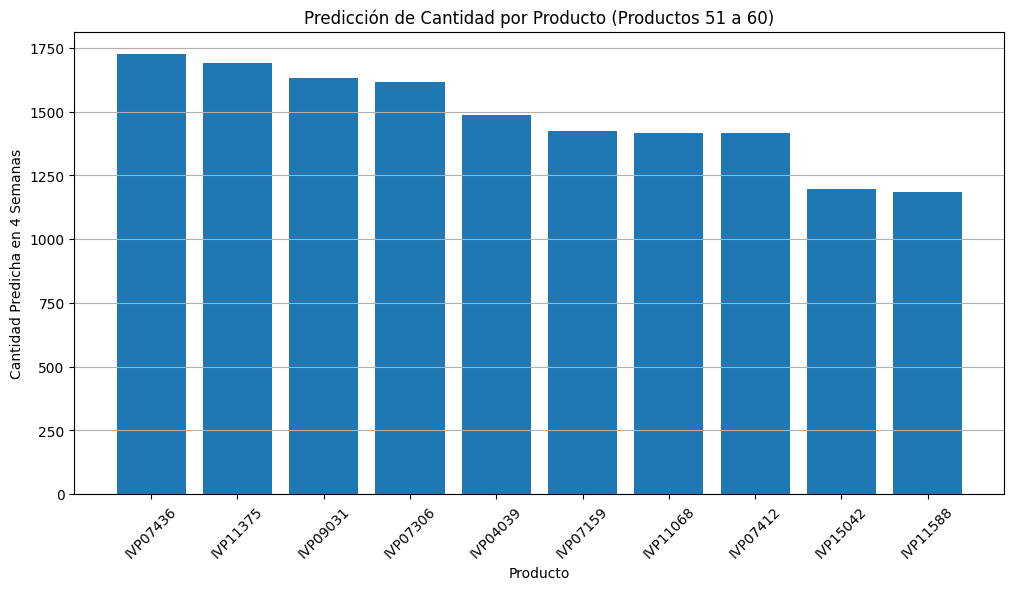

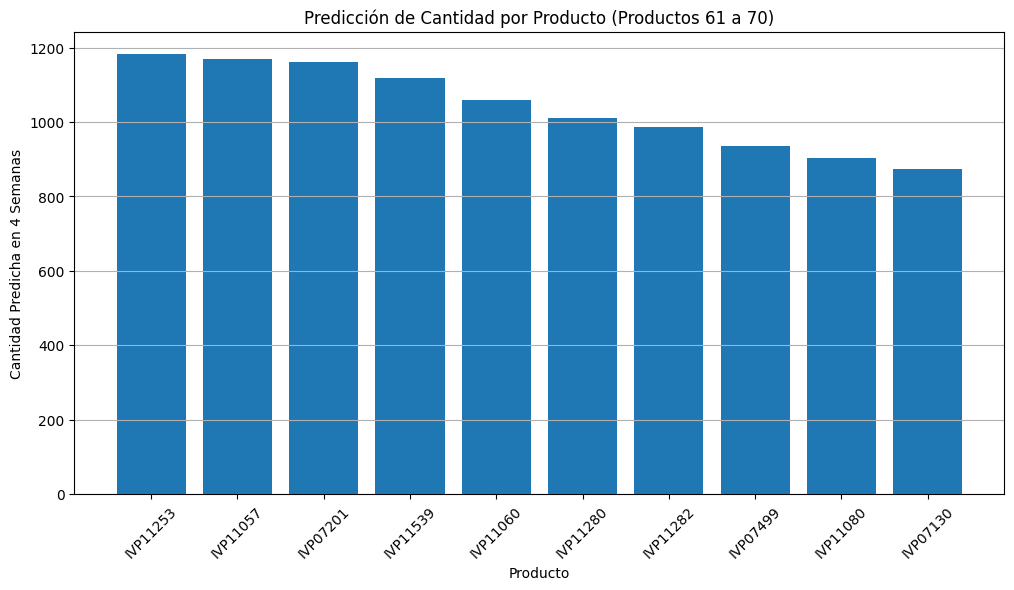

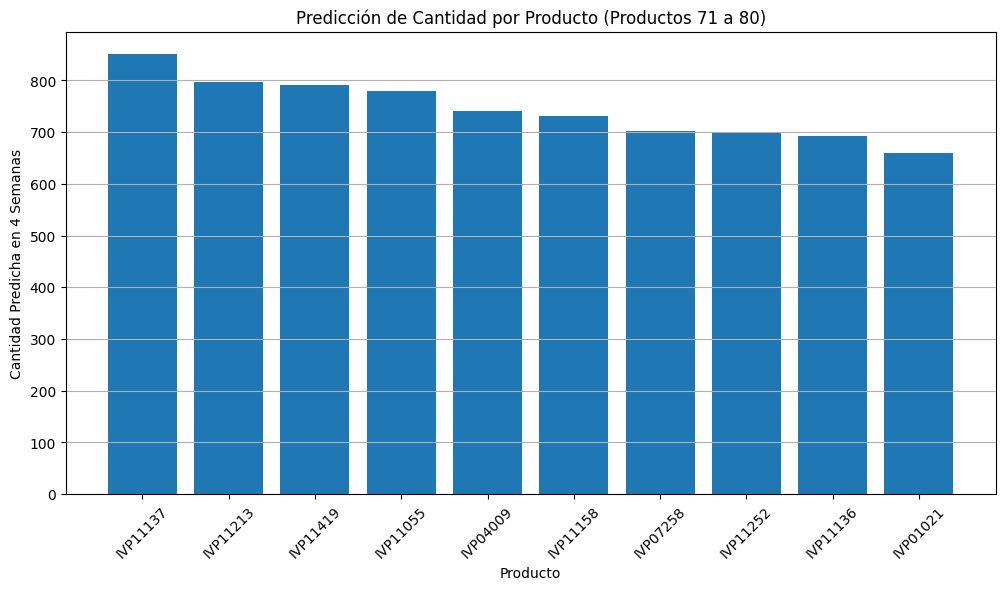

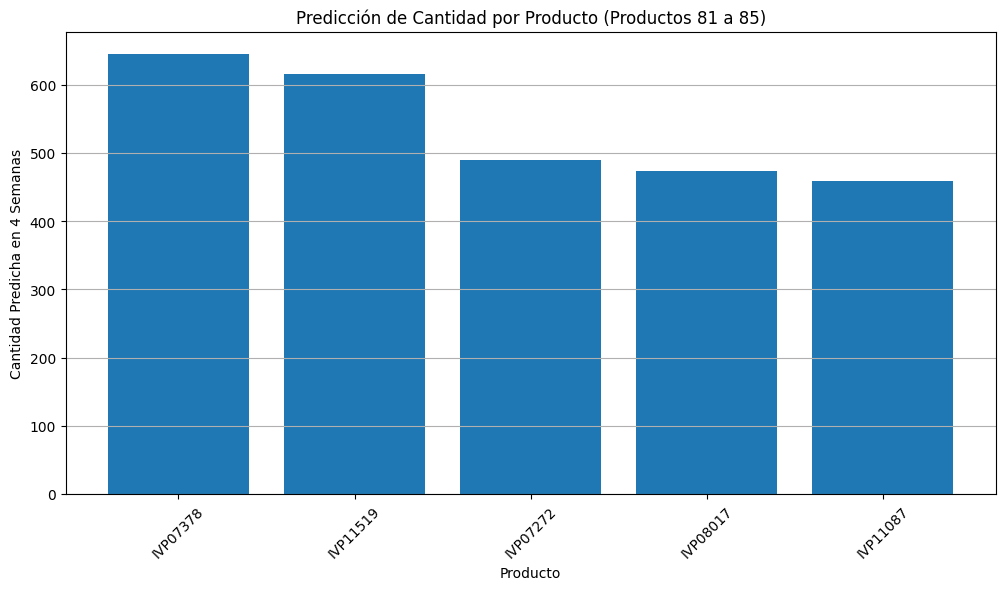

In [6]:
# ===========================
# 6. Visualización
# ===========================
df_resultados1 = pd.DataFrame(resultados)
resultados_df = df_resultados1.sort_values(by='Cant_Pred_Fut_4semanas', ascending=False).reset_index(drop=True)
num_productos = len(resultados_df)
productos_por_grafico = 10
num_graficos = int(np.ceil(num_productos / productos_por_grafico))

for i in range(num_graficos):
    inicio = i * productos_por_grafico
    fin = min((i + 1) * productos_por_grafico, num_productos)
    
    subset = resultados_df.iloc[inicio:fin]
    
    plt.figure(figsize=(12, 6))
    plt.bar(subset['Articulo'], subset['Cant_Pred_Fut_4semanas'])
    plt.title(f'Predicción de Cantidad por Producto (Productos {inicio + 1} a {fin})')
    plt.xlabel('Producto')
    plt.ylabel('Cantidad Predicha en 4 Semanas')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.show()

In [7]:
from prophet import Prophet

df_semanal['Fecha'] = pd.to_datetime(df_semanal['Anio'].astype(str) + '-' + df_semanal['Semana'].astype(str) + '-1', format='%G-%V-%u')
df_prioridad = df_productos_prioridad.copy()
df_prioridad['Producto'] = df_prioridad['Producto'].astype(str)

resultados_prophet = []
descartados = []

print(f"Total de artículos en el top: {len(articulos_top)}")

for articulo in articulos_top:
    if articulo not in df_prioridad['Producto'].values:
        descartados.append((articulo, 'Sin información de prioridad'))
        continue

    fila = df_prioridad[df_prioridad['Producto'] == articulo].iloc[0]
    fuerza_estac = fila['Fuerza_Estacionalidad']
    fuerza_tend = fila['Fuerza_Tendencia']
    score = fila['Score_Prioridad']

    if score < 0.2:
        descartados.append((articulo, 'Score prioridad < 0.2'))
        continue

    df_art = df_semanal[df_semanal['Articulo'] == articulo][['Fecha', 'Cantidad']].copy()
    df_art = df_art.rename(columns={'Fecha': 'ds', 'Cantidad': 'y'})

    rango_fechas = pd.date_range(start=df_art['ds'].min(), end=df_art['ds'].max(), freq='W')
    df_art = df_art.set_index('ds').resample('W').sum().reset_index()

    # Quitar outliers extremos
    y_std = df_art['y'].std()
    y_mean = df_art['y'].mean()
    threshold = y_mean + 4*y_std
    df_art['y'] = np.where(df_art['y'] > threshold, threshold, df_art['y'])

    cap_val = df_art['y'].max() * 1.2
    if cap_val <= 0:
        descartados.append((articulo, 'Ventas máximas = 0'))
        continue

    df_art['cap'] = cap_val
    df_art['floor'] = 0

    growth_type = 'linear' if fuerza_tend > 0.7 else 'logistic'
    changepoint_scale = 0.1 if fuerza_tend > 0.7 else 0.05

    model = Prophet(
        growth=growth_type,
        changepoint_prior_scale=changepoint_scale,
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False
    )

    if fuerza_estac > 0.6:
        model.add_seasonality(name='mensual', period=4, fourier_order=4)
    if fuerza_estac > 0.85:
        model.add_seasonality(name='mensual_fuerte', period=4, fourier_order=6)
    if fuerza_estac > 0.8:
        model.add_seasonality(name='trimestral', period=13, fourier_order=5)

    try:
        model.fit(df_art)

        future = model.make_future_dataframe(periods=4, freq='W')
        future['cap'] = cap_val
        future['floor'] = 0

        forecast = model.predict(future)
        total_pred = forecast.tail(4)['yhat'].sum()

        resultados_prophet.append({
            'Articulo': articulo,
            'Cantidad_predicha_Prophet': total_pred,
            'Fuerza_Estacionalidad': fuerza_estac,
            'Fuerza_Tendencia': fuerza_tend,
            'Score_Prioridad': score
        })

        print(f"✅ Producto {articulo} procesado correctamente.")
    except Exception as e:
        print(f"❌ Error al procesar {articulo}: {e}")
        descartados.append((articulo, f'Error Prophet: {e}'))


/Users/diegovertiz/Documents/Otros/Hackaton Interlub/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
18:58:36 - cmdstanpy - INFO - Chain [1] start processing


Total de artículos en el top: 85


18:58:36 - cmdstanpy - INFO - Chain [1] done processing
18:58:36 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP01021 procesado correctamente.
✅ Producto IVP15248 procesado correctamente.


18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP15246 procesado correctamente.
✅ Producto IVP07378 procesado correctamente.
✅ Producto IVP07099 procesado correctamente.


18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:37 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11065 procesado correctamente.
✅ Producto IVP11633 procesado correctamente.


18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP07383 procesado correctamente.
✅ Producto IVP04039 procesado correctamente.
✅ Producto IVP07293 procesado correctamente.


18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP07169 procesado correctamente.
✅ Producto IVP07370 procesado correctamente.
✅ Producto IVP07331 procesado correctamente.


18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP07243 procesado correctamente.
✅ Producto IVP11588 procesado correctamente.
✅ Producto IVP11080 procesado correctamente.


18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11137 procesado correctamente.


18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP15237 procesado correctamente.
✅ Producto IVP07165 procesado correctamente.
✅ Producto IVP11060 procesado correctamente.


18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP07094 procesado correctamente.
✅ Producto IVP07191 procesado correctamente.


18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP09076 procesado correctamente.
✅ Producto IVP07304 procesado correctamente.
✅ Producto IVP07294 procesado correctamente.


18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP15060 procesado correctamente.
✅ Producto IVP07452 procesado correctamente.
✅ Producto IVP11055 procesado correctamente.


18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP15034 procesado correctamente.
✅ Producto IVP07130 procesado correctamente.
✅ Producto IVP07384 procesado correctamente.


18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP07085 procesado correctamente.
✅ Producto IVP10025 procesado correctamente.
✅ Producto IVP07207 procesado correctamente.


18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP09031 procesado correctamente.
✅ Producto IVP11159 procesado correctamente.
✅ Producto IVP11595 procesado correctamente.


18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11617 procesado correctamente.
✅ Producto IVP07436 procesado correctamente.
✅ Producto IVP07264 procesado correctamente.


18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11479 procesado correctamente.
✅ Producto IVP10009 procesado correctamente.
✅ Producto IVP11586 procesado correctamente.


18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP11162 procesado correctamente.
✅ Producto IVP07446 procesado correctamente.
✅ Producto IVP04009 procesado correctamente.


18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11515 procesado correctamente.
✅ Producto IVP11136 procesado correctamente.
✅ Producto IVP07480 procesado correctamente.


18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP07157 procesado correctamente.
✅ Producto IVP09009 procesado correctamente.
✅ Producto IVP07229 procesado correctamente.


18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11375 procesado correctamente.
✅ Producto IVP11057 procesado correctamente.
✅ Producto IVP11144 procesado correctamente.


18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP07412 procesado correctamente.
✅ Producto IVP11068 procesado correctamente.
✅ Producto IVP11519 procesado correctamente.


18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11087 procesado correctamente.
✅ Producto IVP07131 procesado correctamente.
✅ Producto IVP07306 procesado correctamente.


18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP13011 procesado correctamente.
✅ Producto IVP07499 procesado correctamente.
✅ Producto IVP07341 procesado correctamente.


18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11282 procesado correctamente.
✅ Producto IVP08017 procesado correctamente.
✅ Producto IVP07410 procesado correctamente.


18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11213 procesado correctamente.
✅ Producto IVP11252 procesado correctamente.
✅ Producto IVP07159 procesado correctamente.


18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP07258 procesado correctamente.
✅ Producto IVP11280 procesado correctamente.
✅ Producto IVP07445 procesado correctamente.


18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP11539 procesado correctamente.
✅ Producto IVP09028 procesado correctamente.
✅ Producto IVP11576 procesado correctamente.


18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP07272 procesado correctamente.
✅ Producto IVP07145 procesado correctamente.
✅ Producto IVP15042 procesado correctamente.


18:58:45 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing


✅ Producto IVP07201 procesado correctamente.
✅ Producto IVP11419 procesado correctamente.
✅ Producto IVP11253 procesado correctamente.


18:58:45 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing


✅ Producto IVP11346 procesado correctamente.
✅ Producto IVP09035 procesado correctamente.
✅ Producto IVP11158 procesado correctamente.


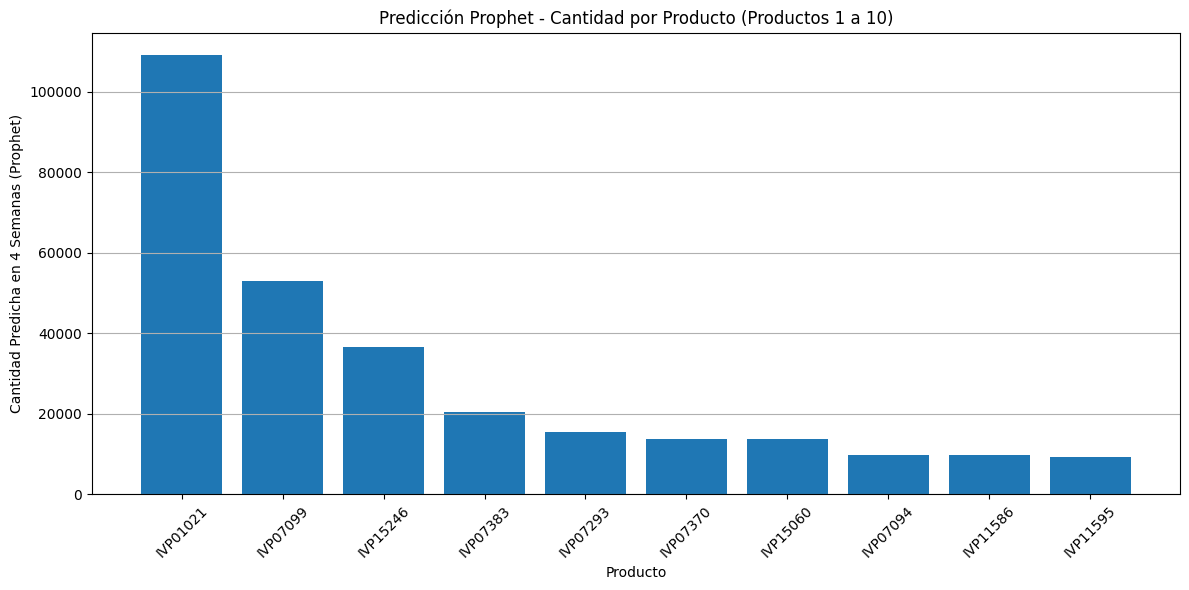

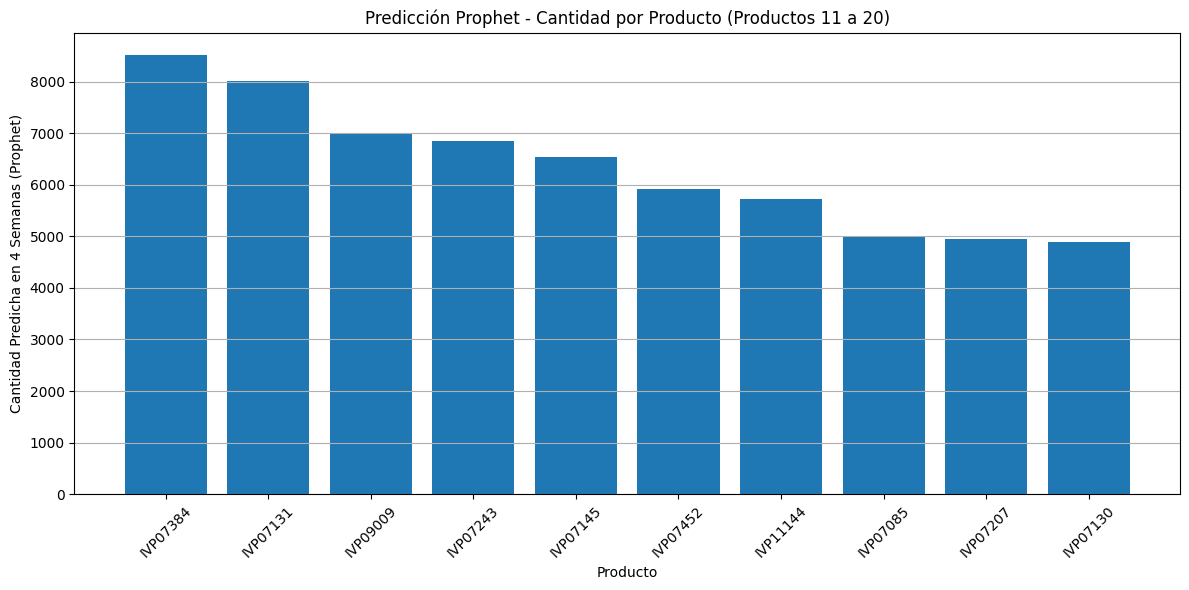

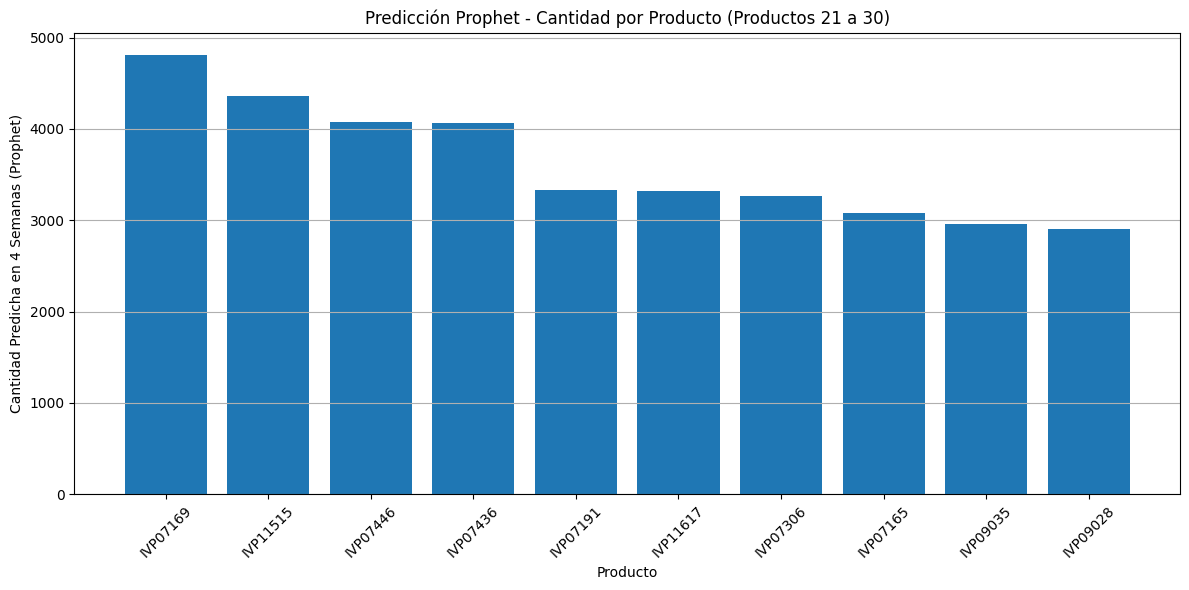

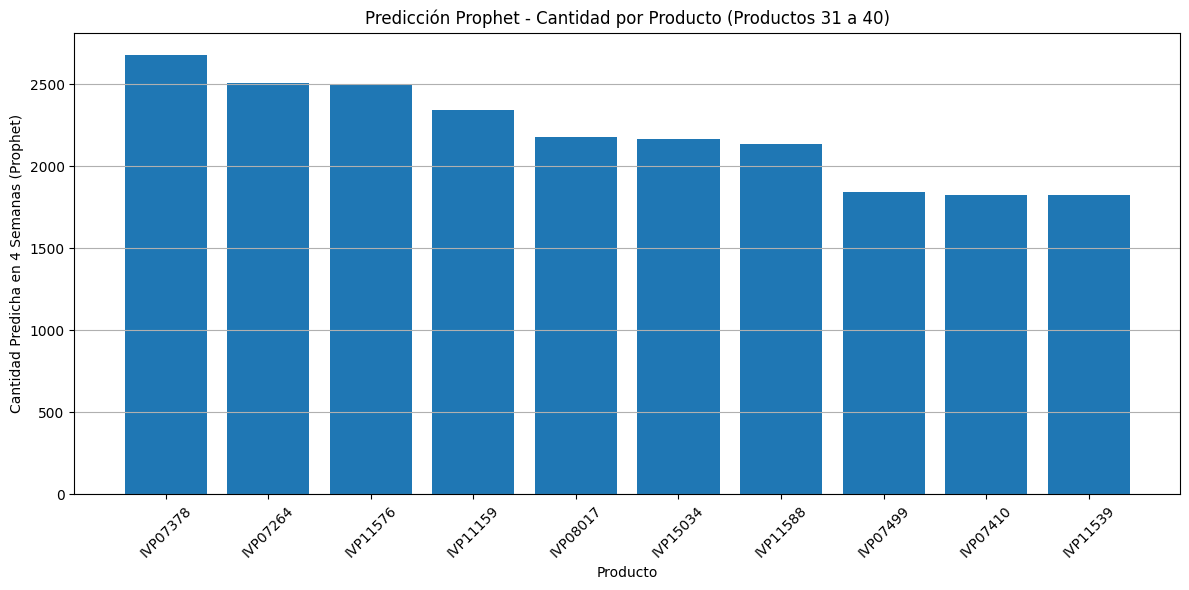

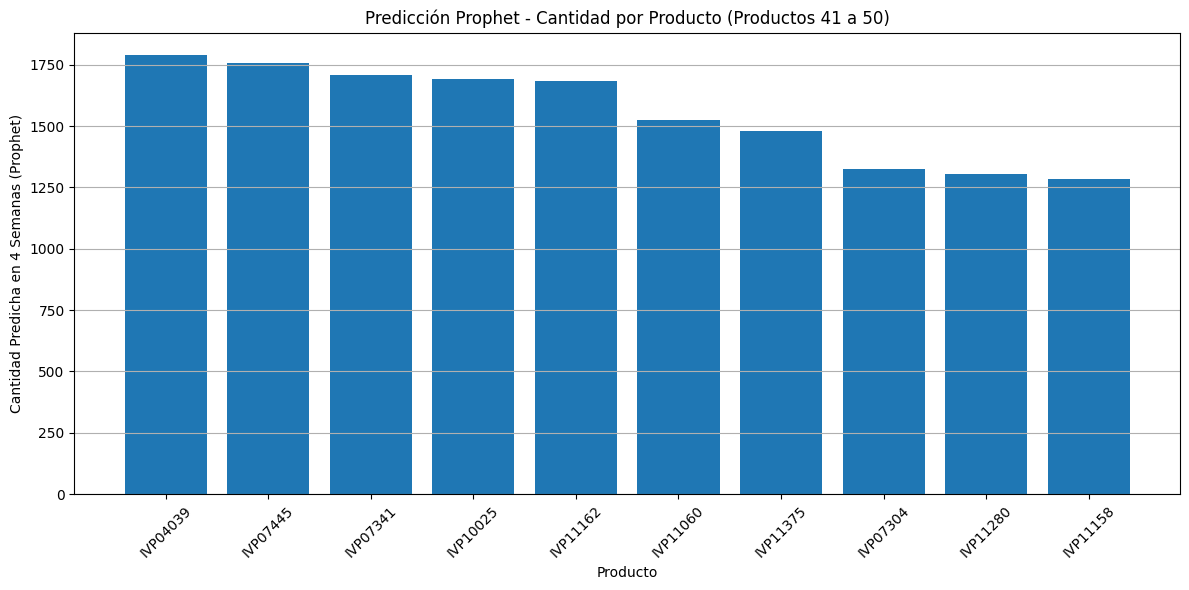

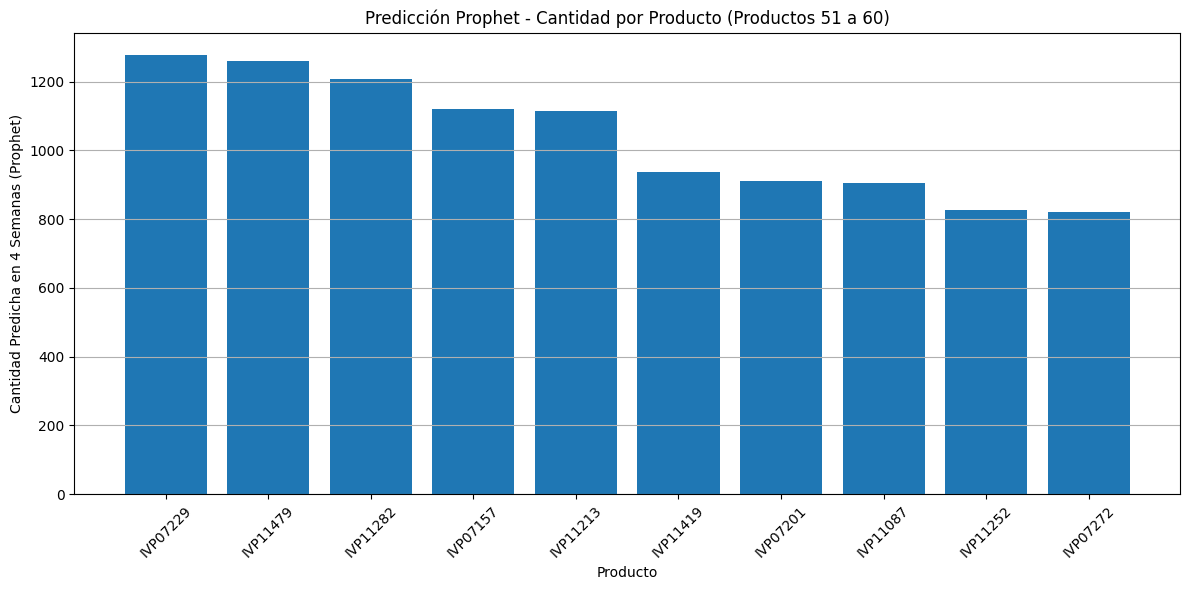

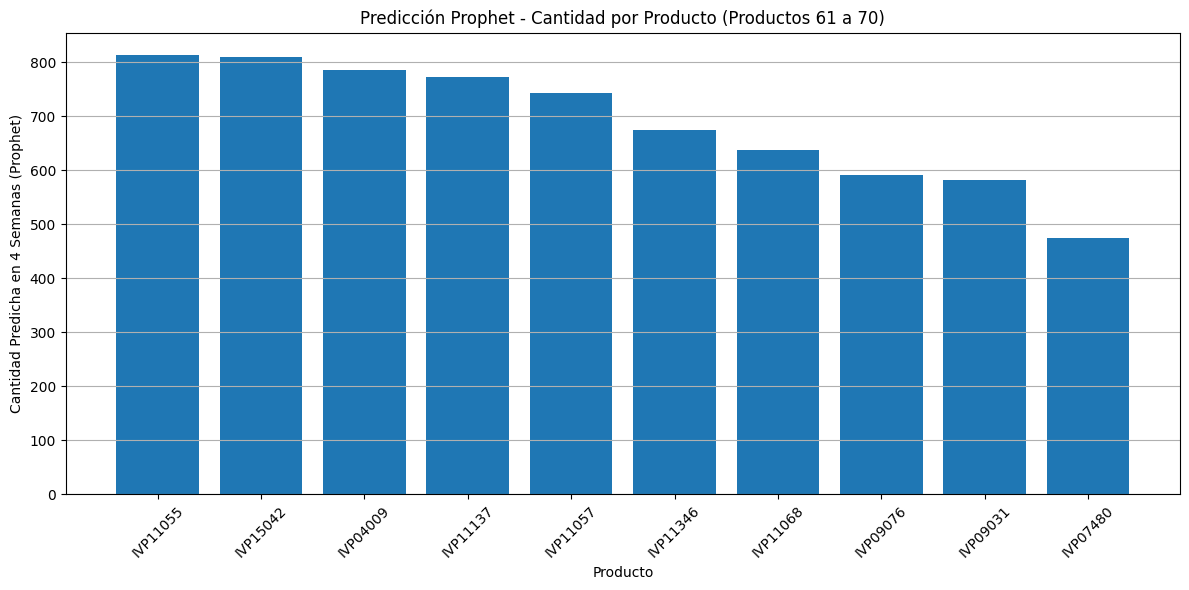

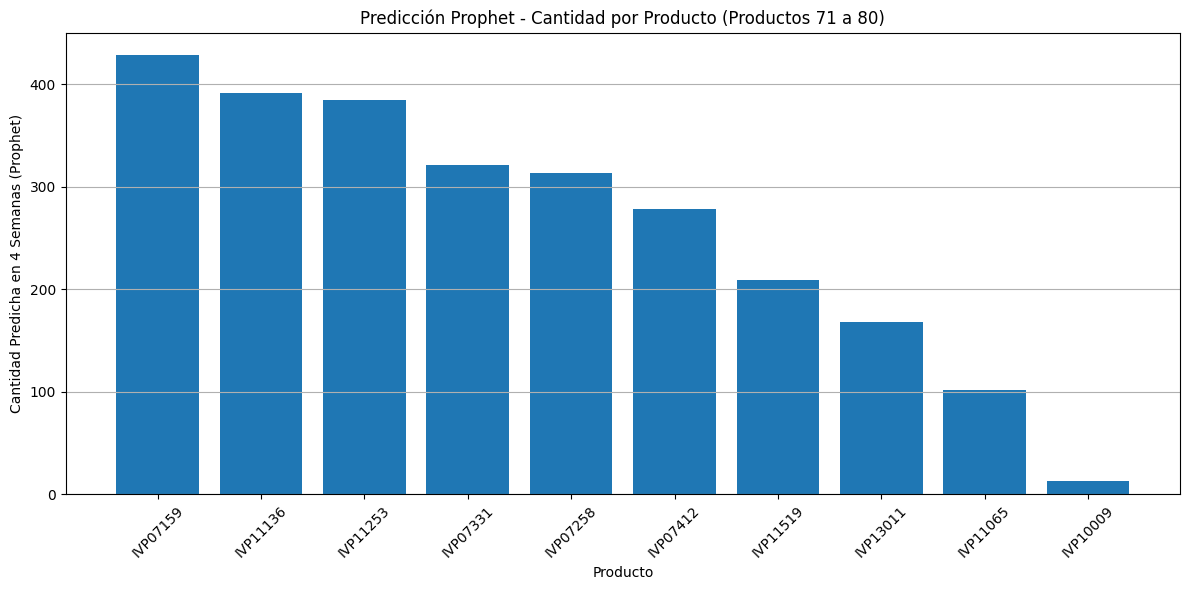

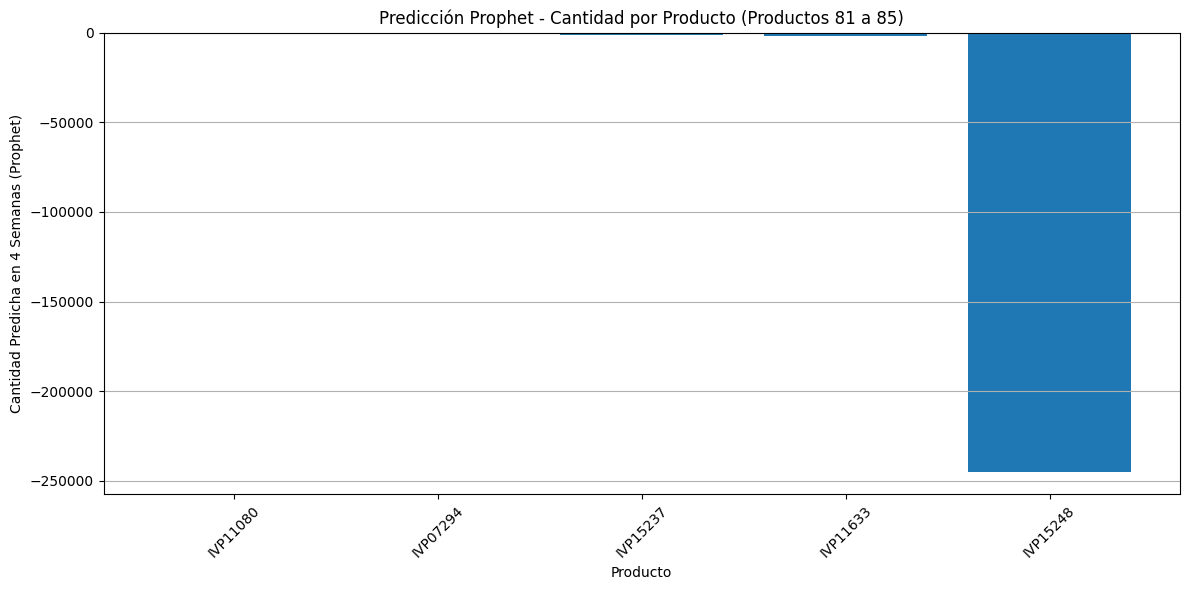

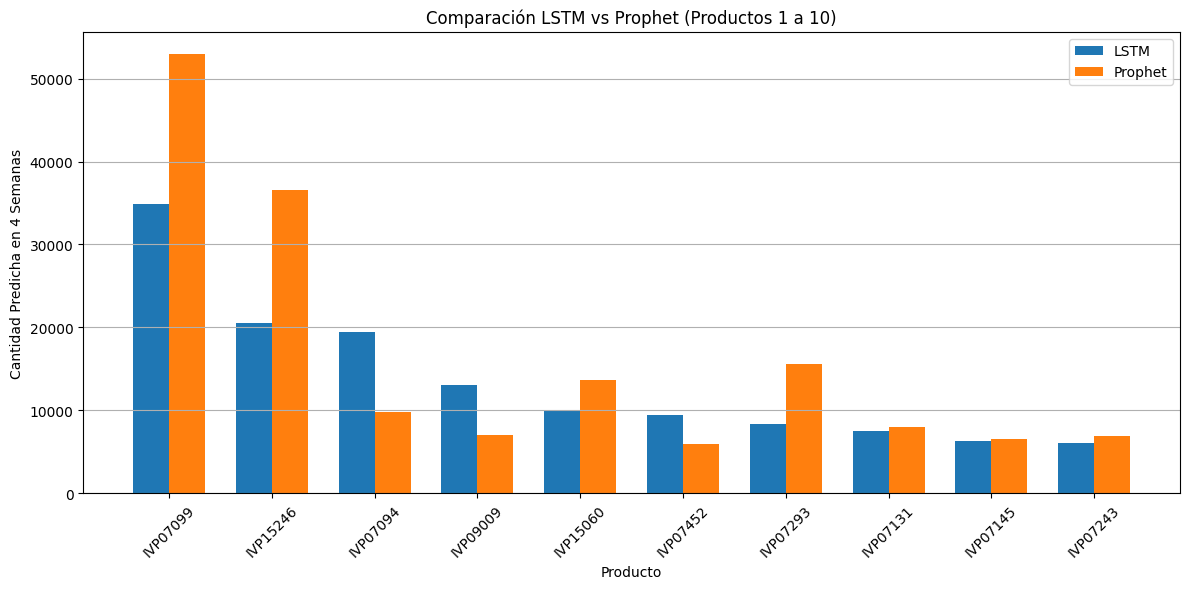

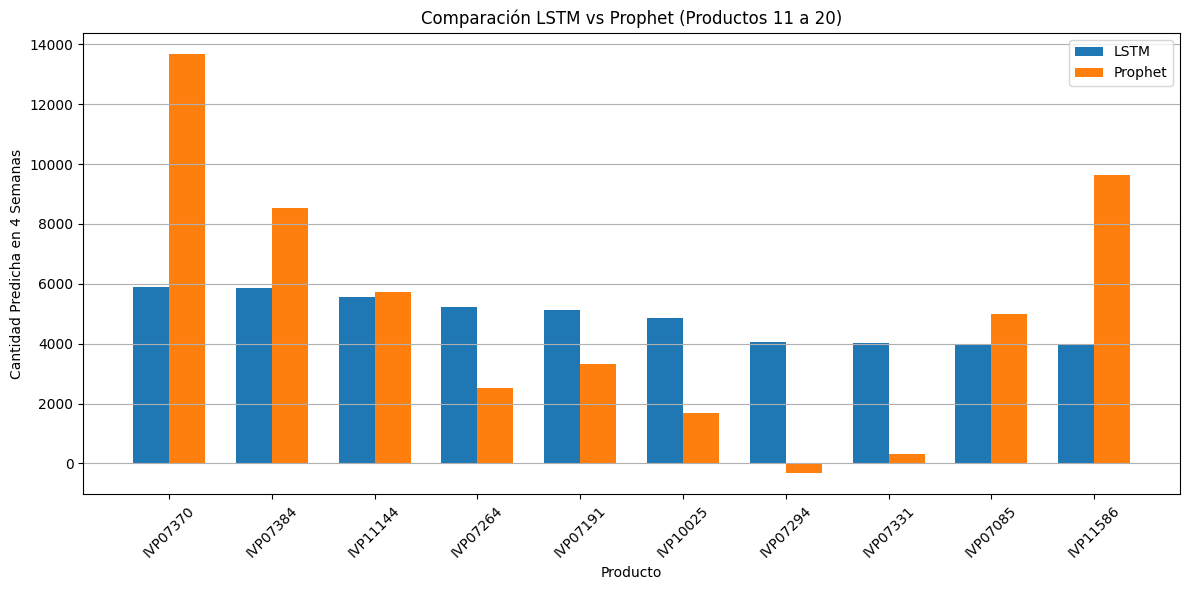

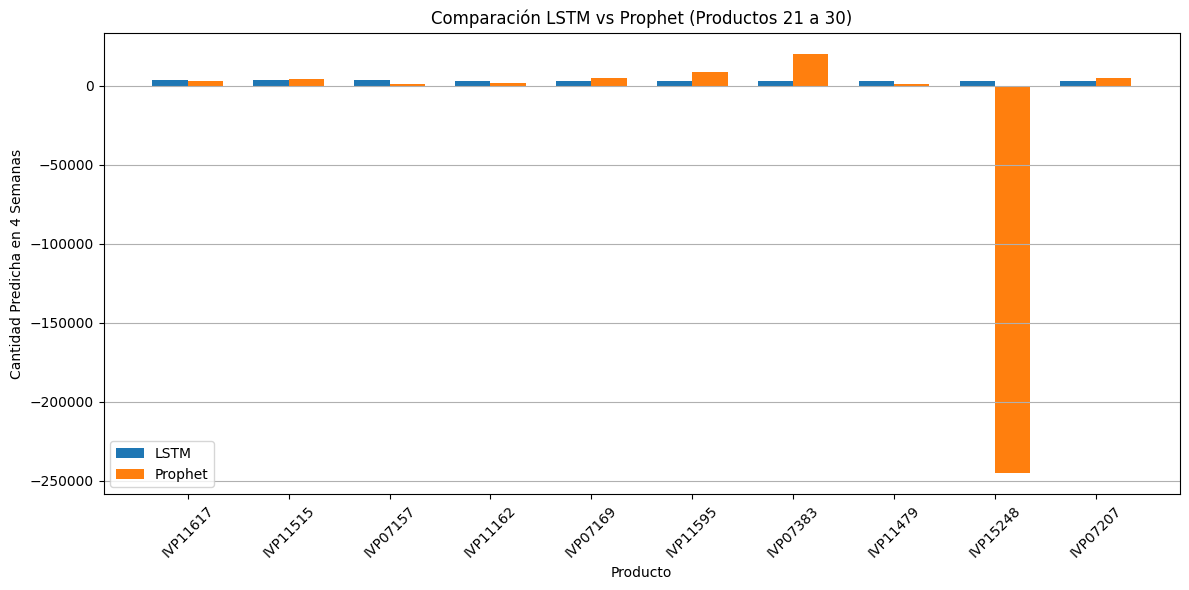

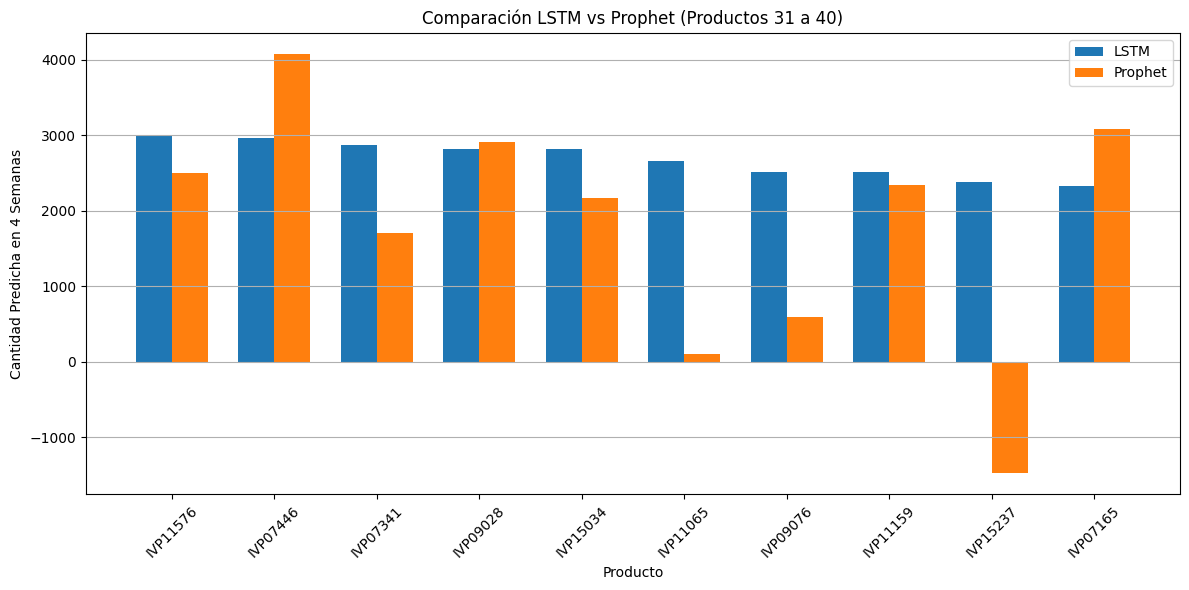

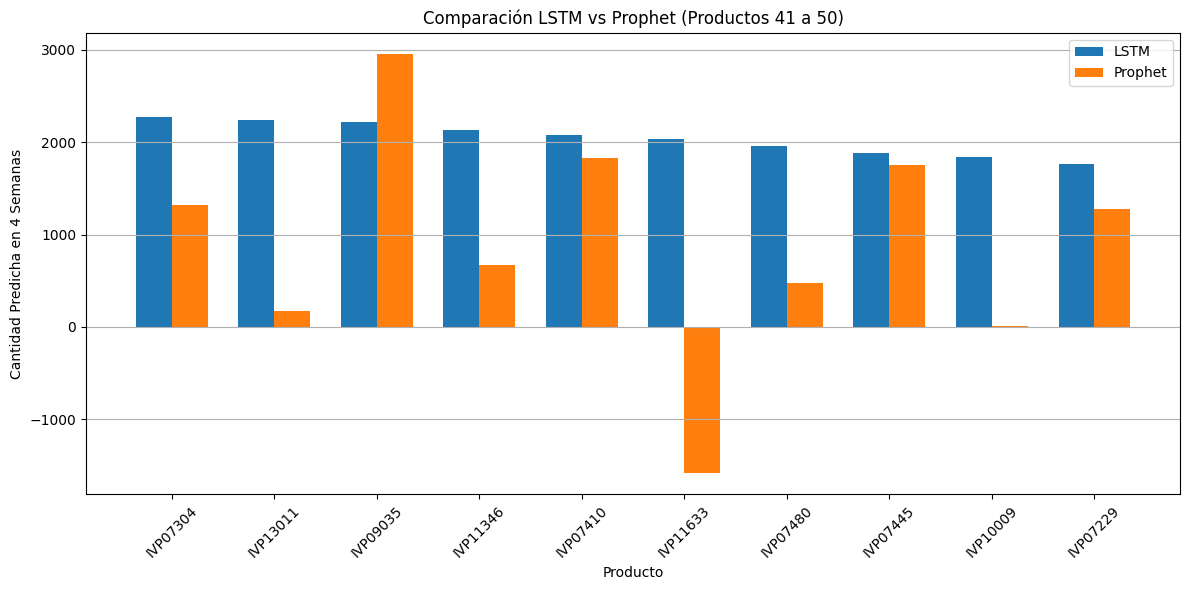

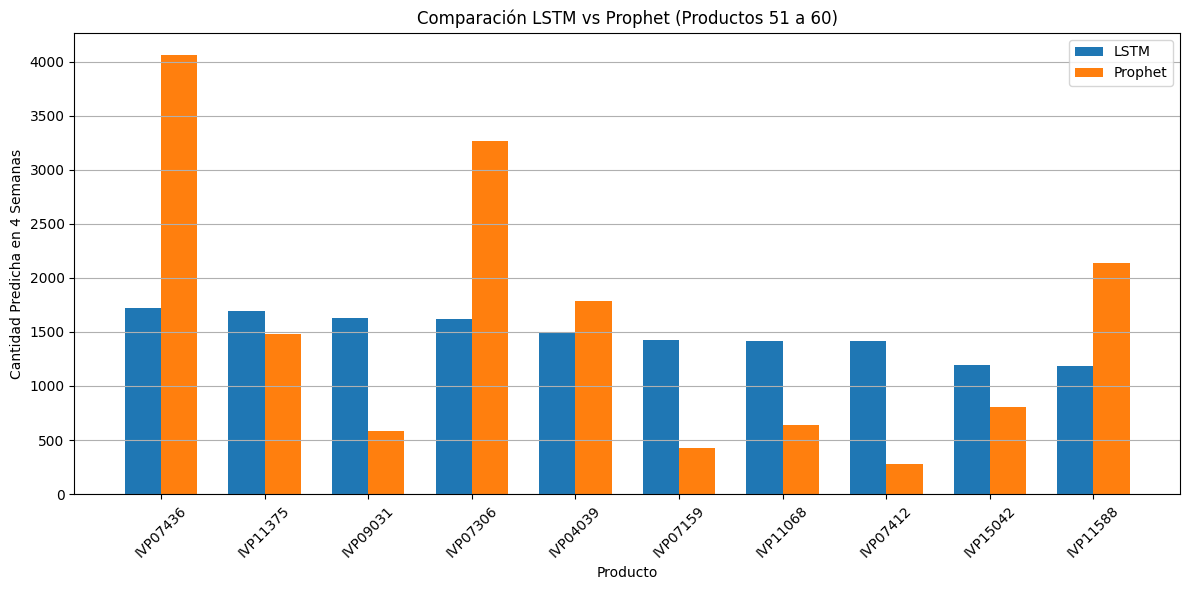

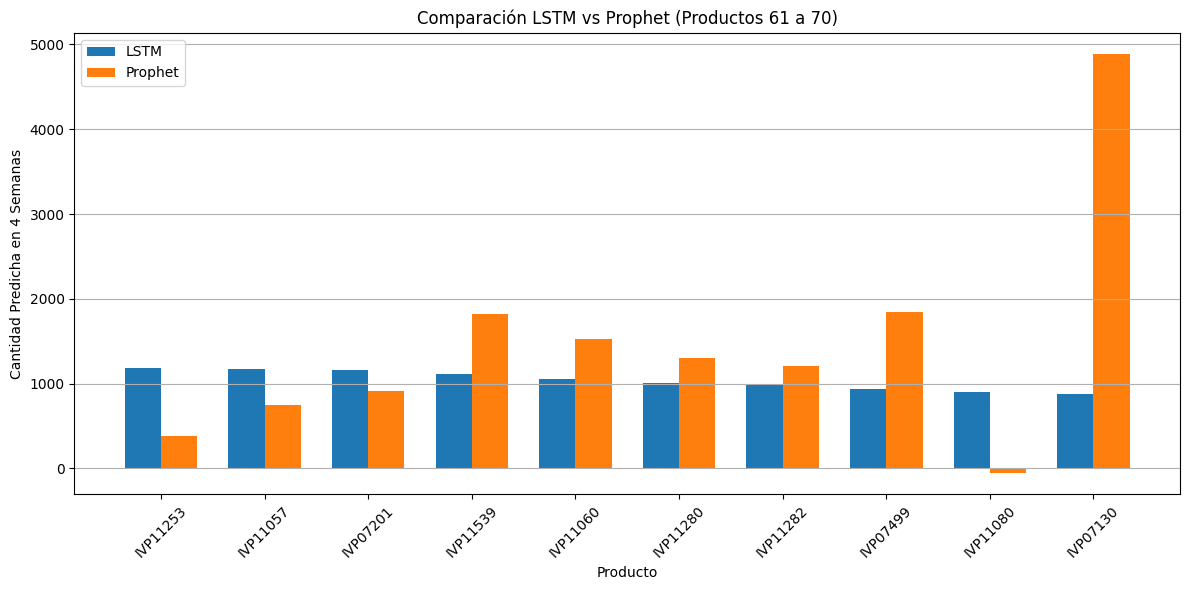

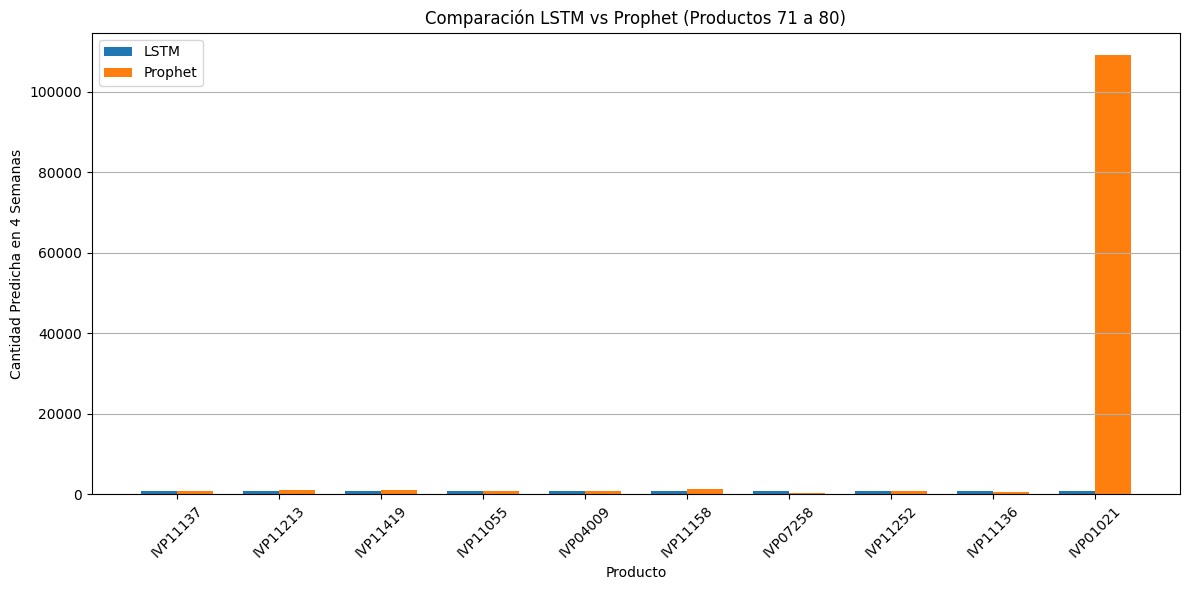

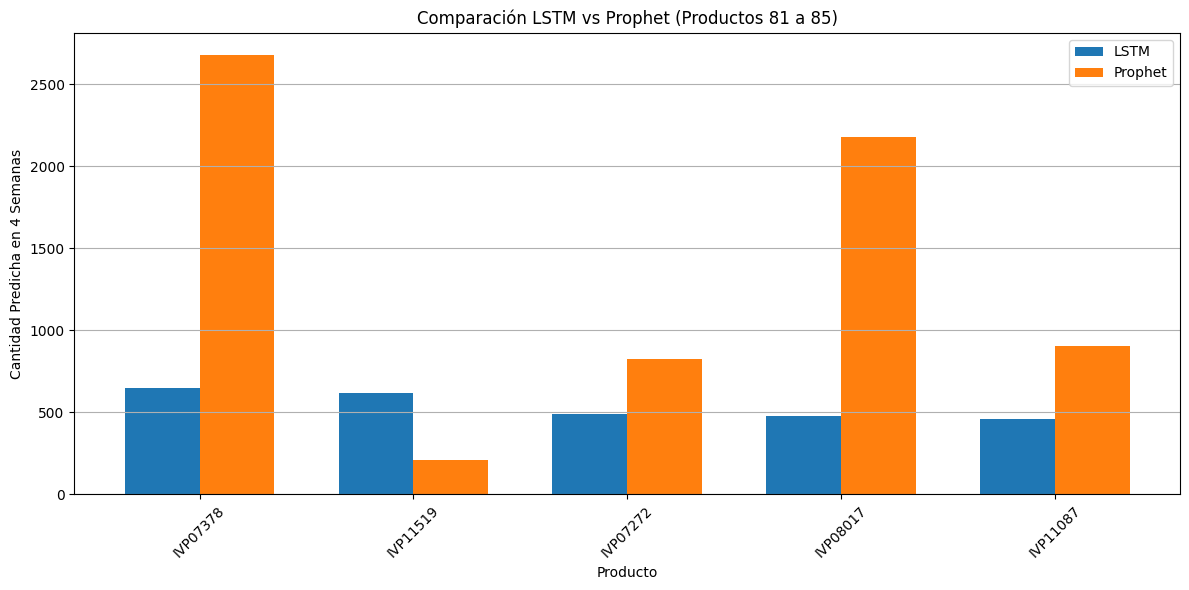

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Suponiendo que ya tienes estas listas en memoria:
# - resultados (LSTM)
# - resultados_prophet (Prophet)

df_resultados1 = pd.DataFrame(resultados)
df_prophet1 = pd.DataFrame(resultados_prophet)

# ===========================
# Gráfico 1: Predicciones Prophet
# ===========================
df_prophet_sorted = df_prophet1.sort_values(by='Cantidad_predicha_Prophet', ascending=False).reset_index(drop=True)
num_productos = len(df_prophet_sorted)
productos_por_grafico = 10
num_graficos = int(np.ceil(num_productos / productos_por_grafico))

for i in range(num_graficos):
    inicio = i * productos_por_grafico
    fin = min((i + 1) * productos_por_grafico, num_productos)

    subset = df_prophet_sorted.iloc[inicio:fin]

    plt.figure(figsize=(12, 6))
    plt.bar(subset['Articulo'], subset['Cantidad_predicha_Prophet'])
    plt.title(f'Predicción Prophet - Cantidad por Producto (Productos {inicio + 1} a {fin})')
    plt.xlabel('Producto')
    plt.ylabel('Cantidad Predicha en 4 Semanas (Prophet)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# ===========================
# Gráfico 2: Comparación LSTM vs Prophet
# ===========================
df_comparacion = df_resultados1.merge(
    df_prophet1[['Articulo', 'Cantidad_predicha_Prophet']],
    on='Articulo', how='inner'
)

df_comparacion_sorted = df_comparacion.sort_values(by='Cant_Pred_Fut_4semanas', ascending=False).reset_index(drop=True)

productos_por_grafico = 10
num_graficos = int(np.ceil(len(df_comparacion_sorted) / productos_por_grafico))

for i in range(num_graficos):
    inicio = i * productos_por_grafico
    fin = min((i + 1) * productos_por_grafico, len(df_comparacion_sorted))

    subset = df_comparacion_sorted.iloc[inicio:fin]

    x = np.arange(len(subset))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, subset['Cant_Pred_Fut_4semanas'], width, label='LSTM')
    plt.bar(x + width/2, subset['Cantidad_predicha_Prophet'], width, label='Prophet')

    plt.title(f'Comparación LSTM vs Prophet (Productos {inicio + 1} a {fin})')
    plt.xlabel('Producto')
    plt.ylabel('Cantidad Predicha en 4 Semanas')
    plt.xticks(x, subset['Articulo'], rotation=45)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_12009/1937472720.py:30: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/diegovertiz/Documents/Otros/Hackaton Interlub/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


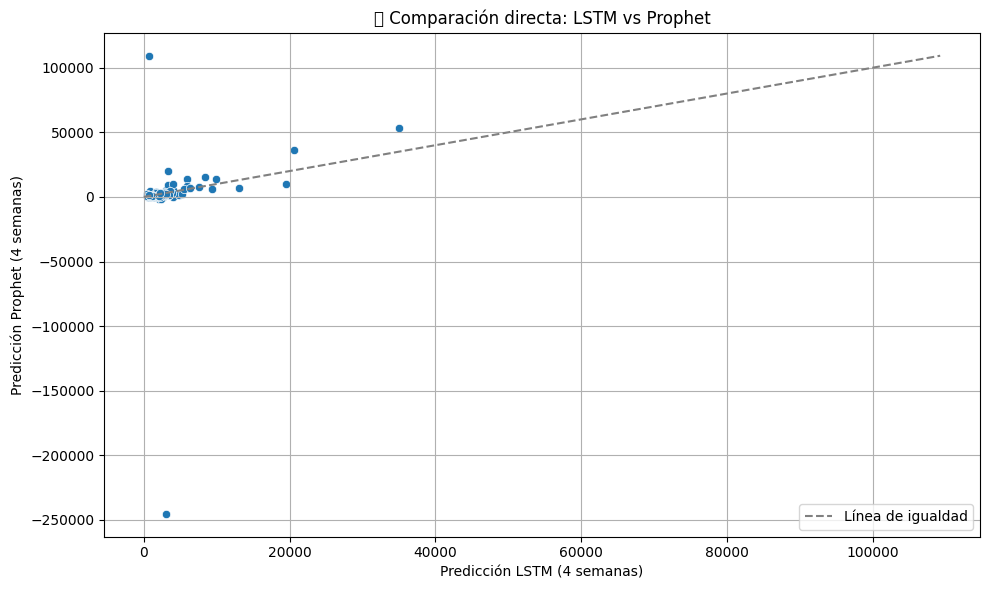

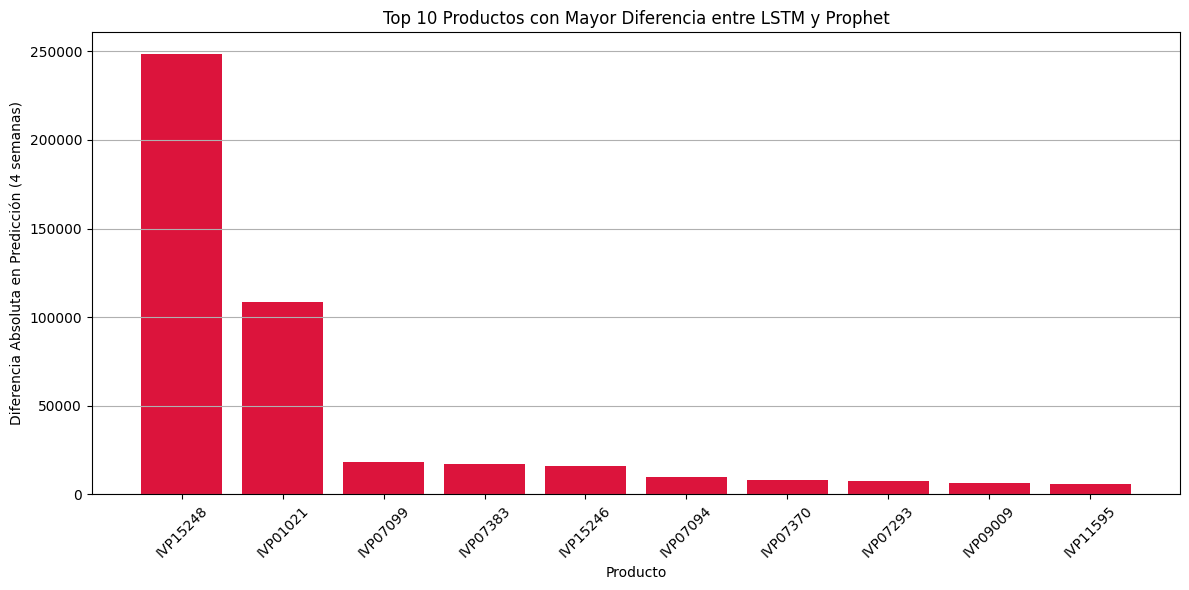

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrames desde los resultados
df_resultados1 = pd.DataFrame(resultados)
df_prophet1 = pd.DataFrame(resultados_prophet)

# Comparación unificada
df_comparacion = df_resultados1.merge(
    df_prophet1[['Articulo', 'Cantidad_predicha_Prophet']],
    on='Articulo', how='inner'
)

# ========= Scatterplot: LSTM vs Prophet =========
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_comparacion,
    x='Cant_Pred_Fut_4semanas',
    y='Cantidad_predicha_Prophet'
)
plt.plot([0, df_comparacion[['Cant_Pred_Fut_4semanas', 'Cantidad_predicha_Prophet']].max().max()],
         [0, df_comparacion[['Cant_Pred_Fut_4semanas', 'Cantidad_predicha_Prophet']].max().max()],
         linestyle='--', color='gray', label='Línea de igualdad')
plt.xlabel('Predicción LSTM (4 semanas)')
plt.ylabel('Predicción Prophet (4 semanas)')
plt.title('🔍 Comparación directa: LSTM vs Prophet')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========= Diferencia absoluta entre modelos =========
df_comparacion['Diferencia_Absoluta'] = abs(df_comparacion['Cant_Pred_Fut_4semanas'] - df_comparacion['Cantidad_predicha_Prophet'])

df_dif_sorted = df_comparacion.sort_values(by='Diferencia_Absoluta', ascending=False).reset_index(drop=True)
top_dif = df_dif_sorted.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_dif['Articulo'], top_dif['Diferencia_Absoluta'], color='crimson')
plt.title('Top 10 Productos con Mayor Diferencia entre LSTM y Prophet')
plt.ylabel('Diferencia Absoluta en Predicción (4 semanas)')
plt.xlabel('Producto')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

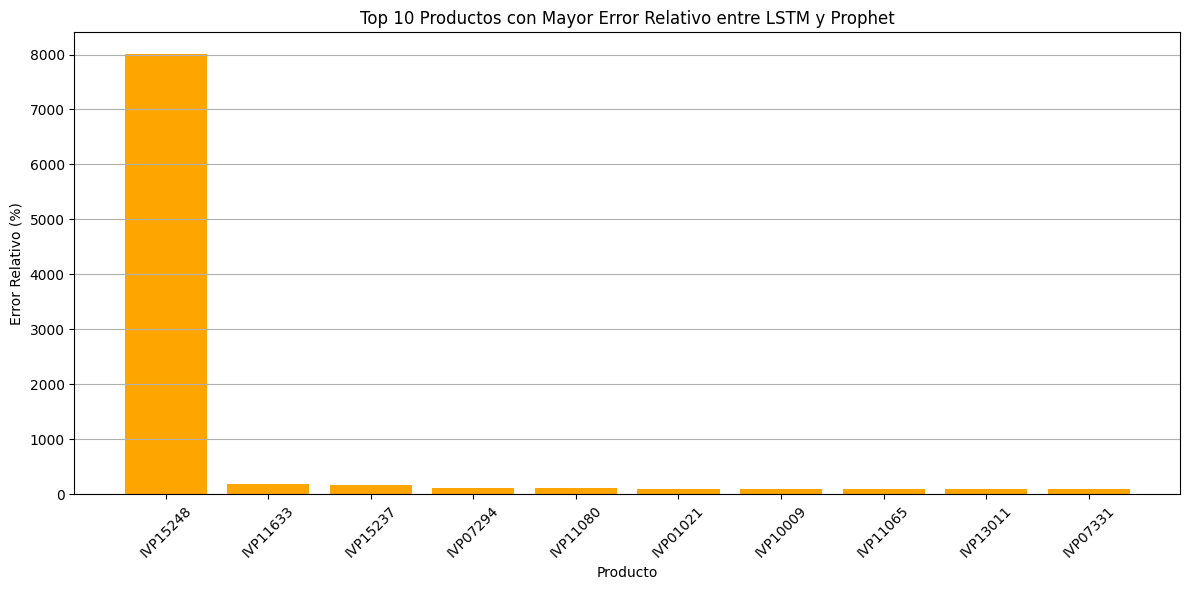

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de tener estas variables en memoria:
# - resultados (LSTM)
# - resultados_prophet (Prophet)

df_resultados1 = pd.DataFrame(resultados)
df_prophet1 = pd.DataFrame(resultados_prophet)

# Unir predicciones
df_comparacion = df_resultados1.merge(
    df_prophet1[['Articulo', 'Cantidad_predicha_Prophet']],
    on='Articulo', how='inner'
)

# Calcular error relativo (%)
df_comparacion['Error_Relativo_%'] = (
    abs(df_comparacion['Cant_Pred_Fut_4semanas'] - df_comparacion['Cantidad_predicha_Prophet']) /
    df_comparacion[['Cant_Pred_Fut_4semanas', 'Cantidad_predicha_Prophet']].max(axis=1)
) * 100

# Top 10 productos con mayor error relativo
df_error_rel = df_comparacion.sort_values(by='Error_Relativo_%', ascending=False).reset_index(drop=True).head(10)

# Gráfico
plt.figure(figsize=(12, 6))
plt.bar(df_error_rel['Articulo'], df_error_rel['Error_Relativo_%'], color='orange')
plt.title('Top 10 Productos con Mayor Error Relativo entre LSTM y Prophet')
plt.ylabel('Error Relativo (%)')
plt.xlabel('Producto')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd

# Asegúrate de tener estas variables:
# - resultados (LSTM)
# - resultados_prophet (Prophet)

df_resultados1 = pd.DataFrame(resultados)
df_prophet1 = pd.DataFrame(resultados_prophet)

# Unificar resultados
df_comparacion = df_resultados1.merge(
    df_prophet1[['Articulo', 'Cantidad_predicha_Prophet']],
    on='Articulo', how='inner'
)

# Calcular métricas
df_comparacion['Diferencia_Absoluta'] = abs(df_comparacion['Cant_Pred_Fut_4semanas'] - df_comparacion['Cantidad_predicha_Prophet'])
df_comparacion['Error_Relativo_%'] = (
    df_comparacion['Diferencia_Absoluta'] / df_comparacion[['Cant_Pred_Fut_4semanas', 'Cantidad_predicha_Prophet']].max(axis=1)
) * 100

# Tabla final
df_resumen = df_comparacion[[
    'Articulo',
    'Cant_Pred_Fut_4semanas',
    'Cantidad_predicha_Prophet',
    'Diferencia_Absoluta',
    'Error_Relativo_%'
]].copy()

# Renombrar columnas para claridad
df_resumen.columns = [
    'Articulo',
    'Pred_LSTM_4semanas',
    'Pred_Prophet_4semanas',
    'Diferencia_Absoluta',
    'Error_Relativo_%'
]

# Exportar si quieres
df_resumen.to_excel("Comparacion_LSTM_vs_Prophet.xlsx", index=False)

In [13]:
# Asegúrate de haber generado df_resumen antes (usa el código anterior)

# Filtrar los más erráticos
df_top_erraticos = df_resumen.sort_values(by='Error_Relativo_%', ascending=False).head(10).reset_index(drop=True)

# Exportar o mostrar
df_top_erraticos.to_excel("Top10_Productos_Erraticos_LSTM_Prophet.xlsx", index=False)
df_top_erraticos

,Articulo,Pred_LSTM_4semanas,Pred_Prophet_4semanas,Diferencia_Absoluta,Error_Relativo_%
0,IVP15248,3102.973633,-245254.385653,248357.359286,8003.850135
1,IVP11633,2035.565918,-1584.723671,3620.289589,177.851749
2,IVP15237,2377.275391,-1474.184238,3851.459628,162.011505
3,IVP07294,4062.938232,-324.610664,4387.548896,107.989554
4,IVP11080,902.695496,-56.173045,958.868541,106.222812
5,IVP01021,658.976440,109233.023423,108574.046983,99.396724
6,IVP10009,1839.043945,12.778536,1826.265409,99.305153
7,IVP11065,2663.168945,101.578243,2561.590702,96.185813
8,IVP13011,2236.138916,167.976727,2068.162189,92.488091
9,IVP07331,4034.185059,321.504968,3712.680091,92.030485


/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_12009/1957924724.py:29: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/diegovertiz/Documents/Otros/Hackaton Interlub/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


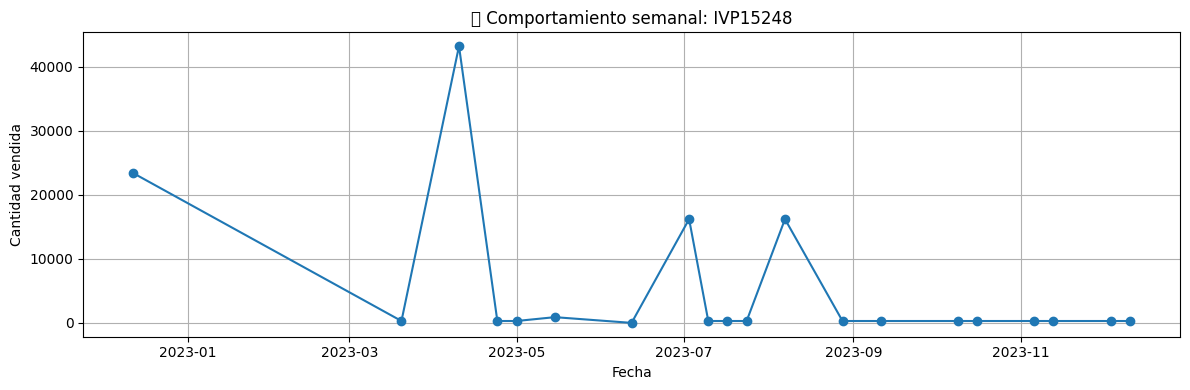

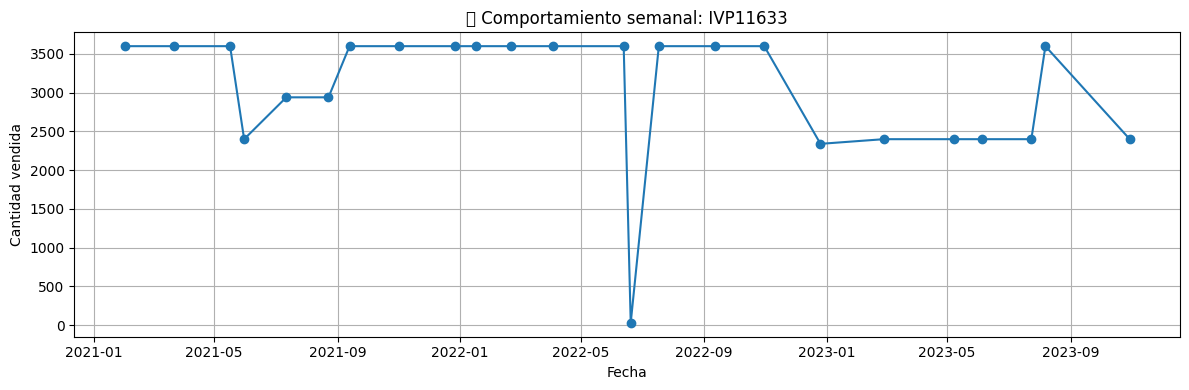

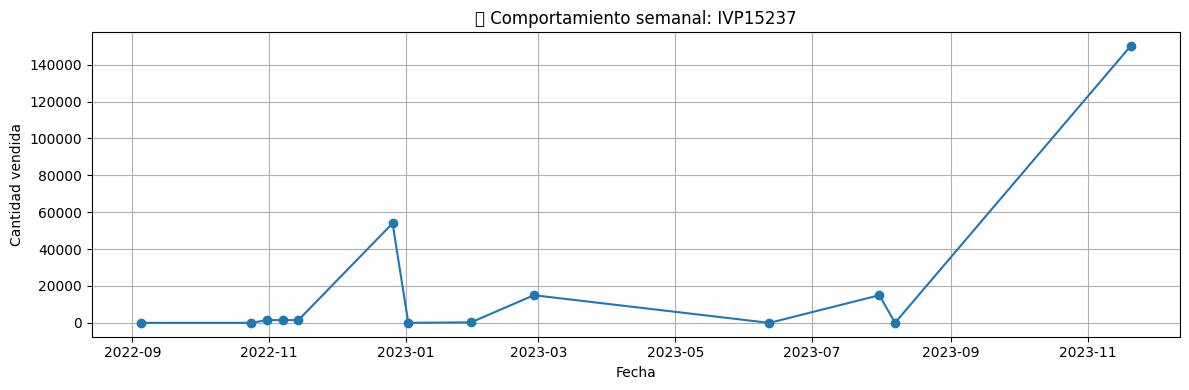

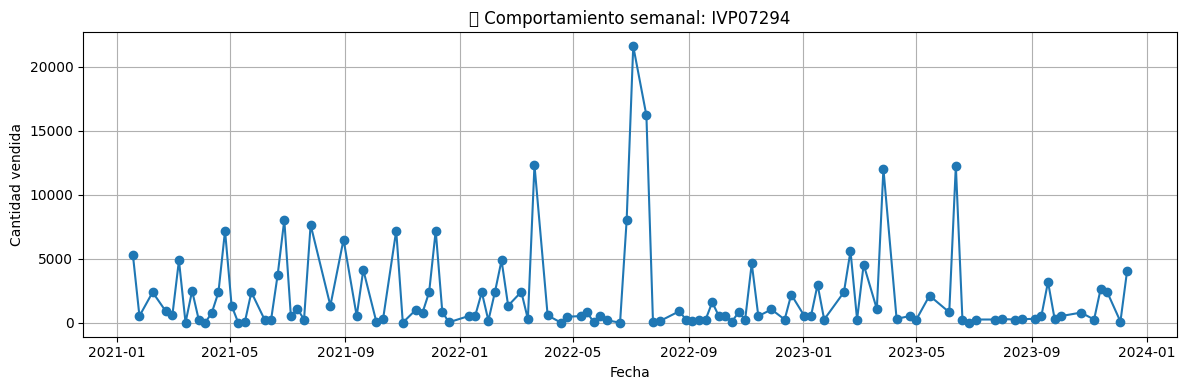

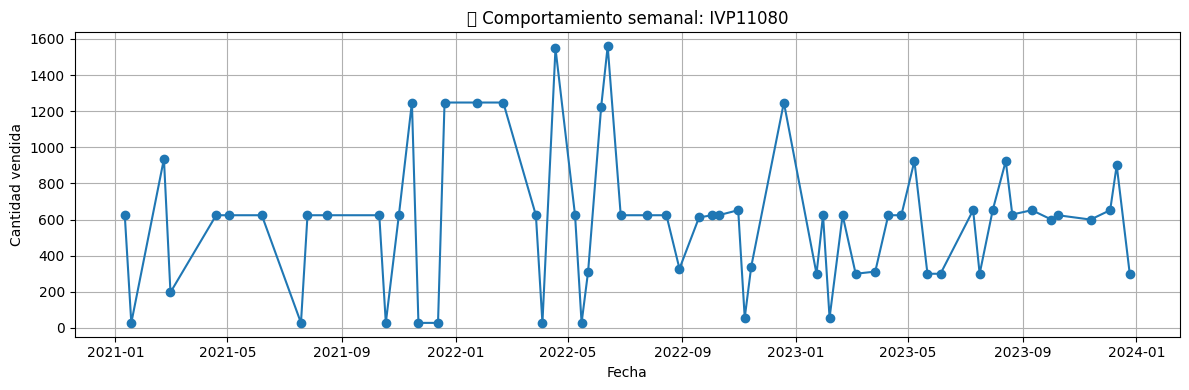

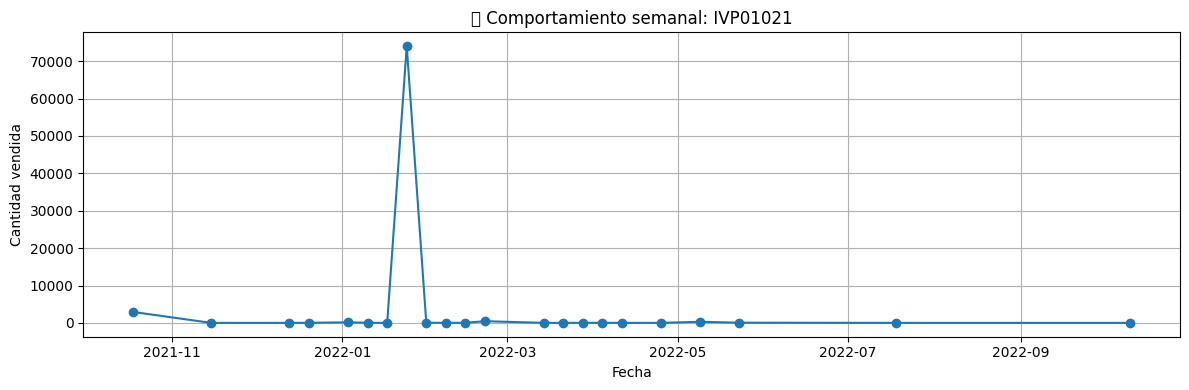

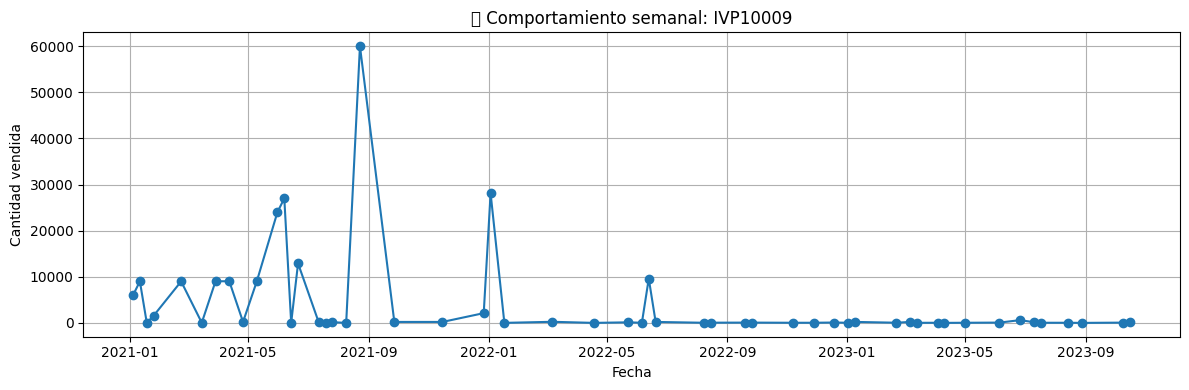

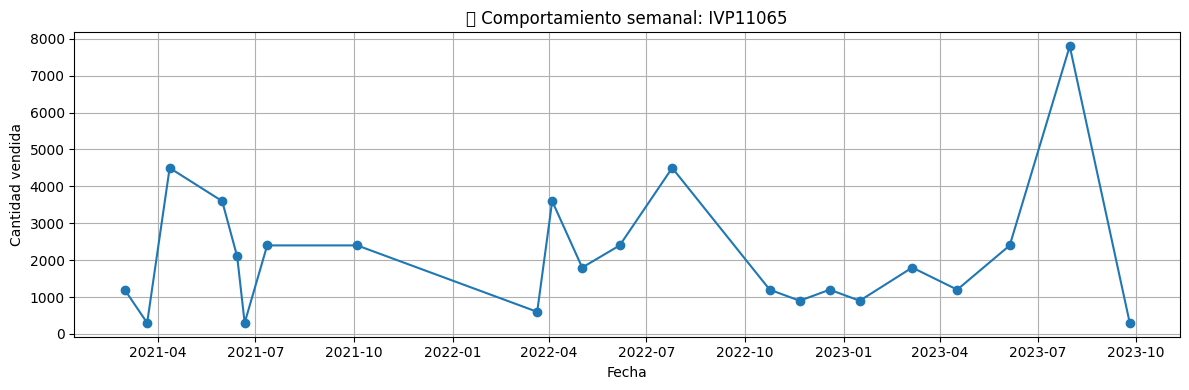

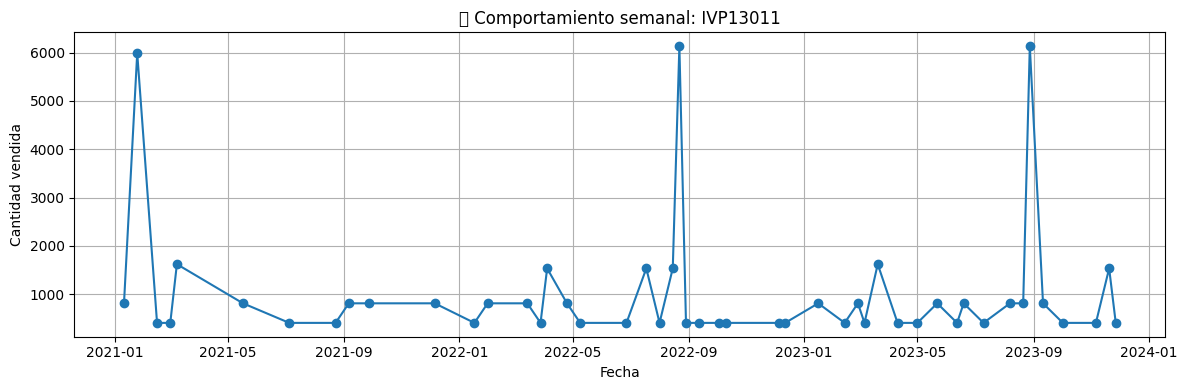

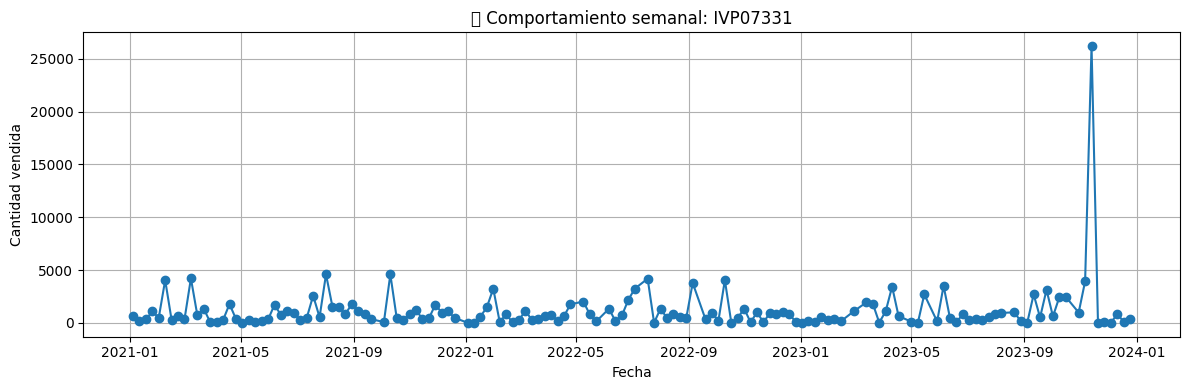

In [14]:
import pandas as pd

# Cargar tus datos originales
df = pd.read_excel("DataHackathon.xlsx")
df['Creacion Orden de Venta'] = pd.to_datetime(df['Creacion Orden de Venta'])
df['Semana'] = df['Creacion Orden de Venta'].dt.isocalendar().week
df['Anio'] = df['Creacion Orden de Venta'].dt.year
df['Fecha'] = pd.to_datetime(df['Anio'].astype(str) + '-' + df['Semana'].astype(str) + '-1', format='%G-%V-%u')

# Filtrar productos erráticos (ya definidos antes)
top_productos_erraticos = df_top_erraticos['Articulo'].tolist()
df_erraticos = df[df['Articulo'].isin(top_productos_erraticos)]

# Agrupar por producto y semana
df_agrupado = df_erraticos.groupby(['Articulo', 'Fecha']).agg({'Cantidad': 'sum'}).reset_index()

# Revisar visualmente los productos
import matplotlib.pyplot as plt

for articulo in top_productos_erraticos:
    datos = df_agrupado[df_agrupado['Articulo'] == articulo]
    
    plt.figure(figsize=(12, 4))
    plt.plot(datos['Fecha'], datos['Cantidad'], marker='o')
    plt.title(f"📦 Comportamiento semanal: {articulo}")
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad vendida')
    plt.grid(True)
    plt.tight_layout()
    plt.show()